In [100]:
import warnings
from matplotlib.ticker import MultipleLocator
import string
from prettytable import PrettyTable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import re
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import ast

In [101]:
df = pd.read_csv("../input/multilabelsongs/MultiLabelSongs_RO.csv")
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,Nu te voi deranja niciodată\nNu voi promite ni...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Începem\nMarele meu ego mă va pune în dificult...,"Power, Tension"


In [102]:
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,Nu te voi deranja niciodată\nNu voi promite ni...,"Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Începem\nMarele meu ego mă va pune în dificult...,"Power, Tension"


In [103]:
df['labels'] = df['labels'].str.split(',\s*')
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,Nu te voi deranja niciodată\nNu voi promite ni...,"[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Începem\nMarele meu ego mă va pune în dificult...,"[Power, Tension]"


In [104]:
all_emotions = sorted(list(set([e for labels in df['labels'] for e in labels])))
mlb = MultiLabelBinarizer(classes=all_emotions)
labels_bin = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [105]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lyrics'].tolist(), labels_bin, test_size=0.2, random_state=42
)

In [106]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=all_emotions, zero_division=0)
    return f1_micro, f1_macro, precision, recall, acc, report, all_labels, all_preds

In [107]:
def plot_confusion_per_class(true_labels, pred_labels, class_names, epoch=None):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not ' + class_name, class_name],
                    yticklabels=['Not ' + class_name, class_name])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        title = f"Confusion Matrix: {class_name}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        plt.title(title)
        plt.tight_layout()
        plt.show()

In [108]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(labels)
        }

class MultiLabelClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits 

In [109]:
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)

idx = 0
sample = train_dataset[idx]
original_text = train_texts[idx]

print("=== Text original ===")
print(original_text)
print("\n=== Token IDs ===")
print(sample['input_ids'])
print("\n=== Attention Mask ===")
print(sample['attention_mask'])
print("\n=== Tokens ===")
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print("\n=== Label ===")
print(sample['labels'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

=== Text original ===
Imaginează toate posibilitățile
Imaginează toate posibilitățile
Sună ca un cântec de dragoste
Sună ca un cântec de dragoste
Cel mai incredibil, iubito
Nu pot să-mi văd ochii
Așa că trebuie să fac melodia să plângă
Nu pot să-mi văd ochii
Așa că trebuie să fac melodia să plângă

Bun tip, știu că mă iubești ca mâncarea gătită
Chiar dacă un nigga trebuie să se miște ca un escroc
Am fost împreună la bloc de la prânzul gratuit
Ar trebui să fim împreună cu Brunch Four Seasons
Obișnuiam să folosim umbrele pentru a ne confrunta cu vremea rea
Deci, acum călătorim clasa întâi pentru a schimba prognoza
Niciodată în ciorchine, doar eu și tu
Mi-a plăcut punctul tău de vedere, pentru că nu ai avut pumni
Totuși te-am lăsat luni întregi
Au trecut luni de când am intrat din nou
Suntem undeva într-un oraș mic
Undeva blochează un mall în jos
Woodgrain, patru și se schimbă, armura a fost jos
Pot să înțeleg de ce vrei un divorț acum
Deși nu vă pot anunța, Mândria nu mă va lăsa să-l ară

In [110]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "xlm-roberta-base"
#model_name = "readerbench/RoBERT-base"
#model_name = "racai/distilbert-base-romanian-cased"
#model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiLabelClassificationModel(model_name, num_labels=len(all_emotions))
model.to(device)

for param in model.model.embeddings.parameters():
    param.requires_grad = True

# Freeze primele 2 layere in encoder
#for name, param in model.model.encoder.named_parameters():
#    if "layer." in name:
#        layer_num = int(name.split('.')[1])
#        if layer_num < 2:
#            param.requires_grad = False

# Calculez pos_weight pe baza distribuției claselor în train_labels
if not isinstance(train_labels, torch.Tensor):
    train_labels_tensor = torch.tensor(train_labels)
else:
    train_labels_tensor = train_labels

pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = train_labels_tensor.shape[0] - pos_counts
pos_weight = neg_counts / pos_counts
print("Pos weight per class:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)

Pos weight per class: tensor([4.1034, 3.8000, 2.4154, 1.6350, 1.5517, 0.9603, 2.1601, 1.3617, 1.0993])


In [112]:
train_losses = []
train_f1micros, train_f1macros, val_f1micros, val_f1macros = [], [], [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accs, val_accs = [], []

best_model_path = "checkpoint.pt"
best_score = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if epoch == 0 and loop.n == 0:
            print("input_ids shape:", input_ids.shape)
            print("attention_mask shape:", attention_mask.shape)
            print("labels shape:", labels.shape)
            print("labels example:", labels[0])

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, _, _, _ = evaluate(model, train_loader)
    train_f1micros.append(train_f1_micro)
    train_f1macros.append(train_f1_macro)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_accs.append(train_acc)

    val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, _, _, _ = evaluate(model, val_loader)
    val_f1micros.append(val_f1_micro)
    val_f1macros.append(val_f1_macro)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_accs.append(val_acc)

    val_score = val_f1_micro + val_f1_macro
    if val_score > best_score:
        best_score = val_score
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(checkpoint, best_model_path)
        print("Checkpoint salvat cu succes.")
        print(f"Model salvat: Epoca {epoch+1} cu scor val total: {val_score:.4f}")

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}, Loss: {avg_train_loss:.4f}")
    print(f" Val  -> F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16, 9])
labels example: tensor([0., 1., 0., 1., 0., 1., 0., 0., 0.], device='cuda:0')


Epoch 1: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, loss=0.797]


Checkpoint salvat cu succes.
Model salvat: Epoca 1 cu scor val total: 1.1712

Epoch 1
Train -> F1 macro: 0.6629, F1 micro: 0.6786, Precision: 0.6129, Recall: 0.7656, Acc: 0.0721, Loss: 0.7392
 Val  -> F1 macro: 0.5762, F1 micro: 0.5950, Precision: 0.5656, Recall: 0.6365, Acc: 0.0270


Epoch 2: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.655]


Checkpoint salvat cu succes.
Model salvat: Epoca 2 cu scor val total: 1.1738

Epoch 2
Train -> F1 macro: 0.6720, F1 micro: 0.6799, Precision: 0.6135, Recall: 0.8059, Acc: 0.0676, Loss: 0.6967
 Val  -> F1 macro: 0.5840, F1 micro: 0.5898, Precision: 0.5568, Recall: 0.6758, Acc: 0.0360


Epoch 3: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.628]


Checkpoint salvat cu succes.
Model salvat: Epoca 3 cu scor val total: 1.2439

Epoch 3
Train -> F1 macro: 0.7058, F1 micro: 0.7133, Precision: 0.6389, Recall: 0.8306, Acc: 0.1036, Loss: 0.6592
 Val  -> F1 macro: 0.6141, F1 micro: 0.6298, Precision: 0.5826, Recall: 0.6934, Acc: 0.0495


Epoch 4: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.509]



Epoch 4
Train -> F1 macro: 0.7427, F1 micro: 0.7534, Precision: 0.6834, Recall: 0.8368, Acc: 0.1610, Loss: 0.6057
 Val  -> F1 macro: 0.5993, F1 micro: 0.6188, Precision: 0.5810, Recall: 0.6395, Acc: 0.0631


Epoch 5: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.509]



Epoch 5
Train -> F1 macro: 0.7450, F1 micro: 0.7542, Precision: 0.6858, Recall: 0.8423, Acc: 0.1610, Loss: 0.5701
 Val  -> F1 macro: 0.5976, F1 micro: 0.6220, Precision: 0.5840, Recall: 0.6456, Acc: 0.0811


Epoch 6: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.589]



Epoch 6
Train -> F1 macro: 0.7567, F1 micro: 0.7645, Precision: 0.6984, Recall: 0.8532, Acc: 0.1734, Loss: 0.5474
 Val  -> F1 macro: 0.5886, F1 micro: 0.6099, Precision: 0.5713, Recall: 0.6343, Acc: 0.0676


Epoch 7: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.517]



Epoch 7
Train -> F1 macro: 0.7703, F1 micro: 0.7744, Precision: 0.7113, Recall: 0.8688, Acc: 0.1903, Loss: 0.5156
 Val  -> F1 macro: 0.5888, F1 micro: 0.6133, Precision: 0.5703, Recall: 0.6467, Acc: 0.0721


Epoch 8: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.411]



Epoch 8
Train -> F1 macro: 0.8029, F1 micro: 0.8074, Precision: 0.7584, Recall: 0.8656, Acc: 0.2725, Loss: 0.4914
 Val  -> F1 macro: 0.5763, F1 micro: 0.6016, Precision: 0.5770, Recall: 0.5845, Acc: 0.0721


Epoch 9: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.52] 



Epoch 9
Train -> F1 macro: 0.8181, F1 micro: 0.8176, Precision: 0.7660, Recall: 0.8860, Acc: 0.2905, Loss: 0.4725
 Val  -> F1 macro: 0.5867, F1 micro: 0.6183, Precision: 0.5715, Recall: 0.6095, Acc: 0.0676


Epoch 10: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.461]



Epoch 10
Train -> F1 macro: 0.8074, F1 micro: 0.8102, Precision: 0.7580, Recall: 0.8852, Acc: 0.2523, Loss: 0.4345
 Val  -> F1 macro: 0.5779, F1 micro: 0.5973, Precision: 0.5686, Recall: 0.6166, Acc: 0.0450


Epoch 11: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.409]



Epoch 11
Train -> F1 macro: 0.8418, F1 micro: 0.8407, Precision: 0.8025, Recall: 0.8933, Acc: 0.3209, Loss: 0.4138
 Val  -> F1 macro: 0.5666, F1 micro: 0.6042, Precision: 0.5651, Recall: 0.5765, Acc: 0.0991


Epoch 12: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.426]



Epoch 12
Train -> F1 macro: 0.8490, F1 micro: 0.8493, Precision: 0.8149, Recall: 0.8982, Acc: 0.3570, Loss: 0.3837
 Val  -> F1 macro: 0.5617, F1 micro: 0.5862, Precision: 0.5732, Recall: 0.5705, Acc: 0.0766


Epoch 13: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.296]



Epoch 13
Train -> F1 macro: 0.8746, F1 micro: 0.8735, Precision: 0.8292, Recall: 0.9351, Acc: 0.4178, Loss: 0.3575
 Val  -> F1 macro: 0.5763, F1 micro: 0.6069, Precision: 0.5733, Recall: 0.6058, Acc: 0.0586


Epoch 14: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.335]



Epoch 14
Train -> F1 macro: 0.8962, F1 micro: 0.8884, Precision: 0.8652, Recall: 0.9347, Acc: 0.4707, Loss: 0.3267
 Val  -> F1 macro: 0.5780, F1 micro: 0.6130, Precision: 0.5877, Recall: 0.5905, Acc: 0.0856


Epoch 15: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.33] 



Epoch 15
Train -> F1 macro: 0.9050, F1 micro: 0.9004, Precision: 0.8735, Recall: 0.9444, Acc: 0.5169, Loss: 0.3030
 Val  -> F1 macro: 0.5729, F1 micro: 0.6038, Precision: 0.5725, Recall: 0.5915, Acc: 0.0676


Epoch 16: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.232]



Epoch 16
Train -> F1 macro: 0.9150, F1 micro: 0.9092, Precision: 0.8914, Recall: 0.9448, Acc: 0.5597, Loss: 0.2772
 Val  -> F1 macro: 0.5551, F1 micro: 0.5874, Precision: 0.5729, Recall: 0.5552, Acc: 0.0721


Epoch 17: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.249]



Epoch 17
Train -> F1 macro: 0.9426, F1 micro: 0.9337, Precision: 0.9284, Recall: 0.9580, Acc: 0.6599, Loss: 0.2551
 Val  -> F1 macro: 0.5482, F1 micro: 0.5925, Precision: 0.5727, Recall: 0.5389, Acc: 0.0946


Epoch 18: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.194]



Epoch 18
Train -> F1 macro: 0.9431, F1 micro: 0.9361, Precision: 0.9268, Recall: 0.9619, Acc: 0.6678, Loss: 0.2381
 Val  -> F1 macro: 0.5529, F1 micro: 0.5858, Precision: 0.5581, Recall: 0.5610, Acc: 0.0586


Epoch 19: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.29] 



Epoch 19
Train -> F1 macro: 0.9513, F1 micro: 0.9451, Precision: 0.9522, Recall: 0.9523, Acc: 0.7106, Loss: 0.2117
 Val  -> F1 macro: 0.5390, F1 micro: 0.5788, Precision: 0.5807, Recall: 0.5258, Acc: 0.0676


Epoch 20: 100%|██████████| 56/56 [00:59<00:00,  1.07s/it, loss=0.172]



Epoch 20
Train -> F1 macro: 0.9656, F1 micro: 0.9589, Precision: 0.9602, Recall: 0.9725, Acc: 0.7714, Loss: 0.1968
 Val  -> F1 macro: 0.5498, F1 micro: 0.5891, Precision: 0.5822, Recall: 0.5402, Acc: 0.0856


In [113]:
def load_model_from_checkpoint(path, model_name, num_labels, device):
    model = MultiLabelClassificationModel(model_name, num_labels)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['best_score']


GENERAL PERFORMANCE AFTER TRAINING
Train:
F1 macro: 0.7058, F1 micro: 0.7133, Precision: 0.6389, Recall: 0.8306, Acc: 0.1036
                   precision    recall  f1-score   support

        Amazement       0.46      0.93      0.62       174
         Calmness       0.38      0.88      0.53       185
Joyful activation       0.69      0.91      0.78       260
        Nostalgia       0.53      0.85      0.65       337
            Power       0.80      0.75      0.77       348
          Sadness       0.78      0.87      0.83       453
        Solemnity       0.50      0.76      0.60       281
       Tenderness       0.86      0.82      0.84       376
          Tension       0.75      0.72      0.73       423

        micro avg       0.63      0.82      0.71      2837
        macro avg       0.64      0.83      0.71      2837
     weighted avg       0.68      0.82      0.73      2837
      samples avg       0.65      0.84      0.71      2837


Validation:
F1 macro: 0.6141, F1 micro: 0.62

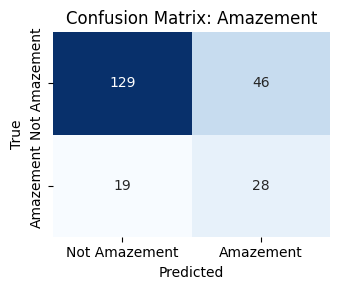

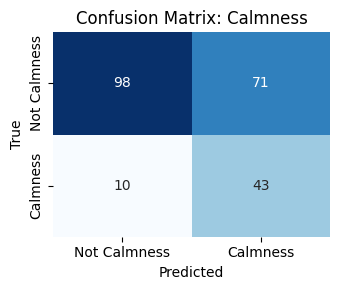

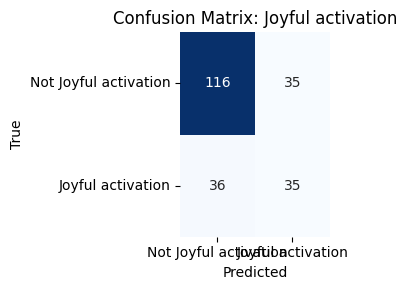

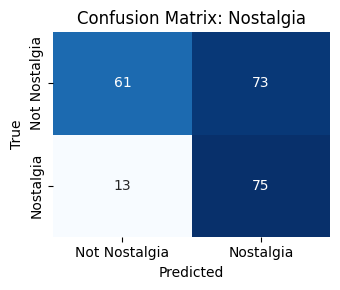

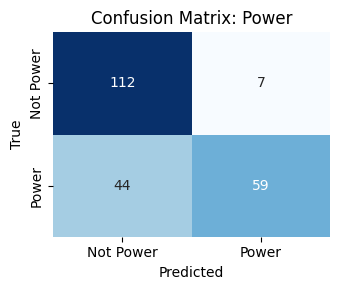

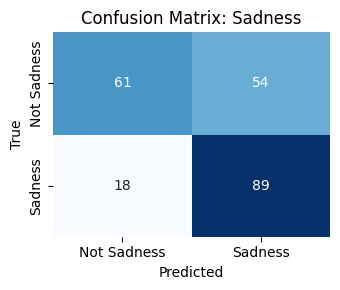

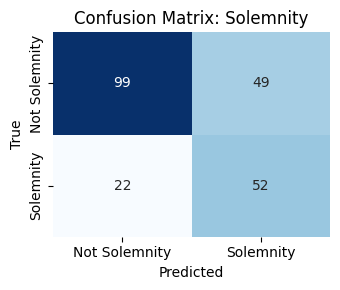

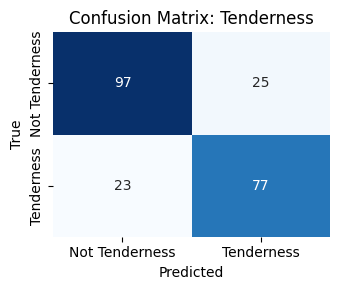

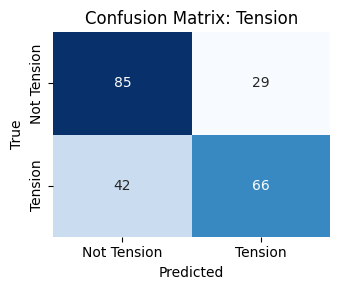

In [114]:
model_path = best_model_path

model, last_epoch, best_score = load_model_from_checkpoint(
    path=model_path,
    model_name=model_name,
    num_labels=len(all_emotions),
    device=device
)

model.eval()

train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, train_report, _, _ = evaluate(model, train_loader)
val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, val_report, val_labels, val_preds = evaluate(model, val_loader)

print("\nGENERAL PERFORMANCE AFTER TRAINING")
print("Train:")
print(f"F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}")
print(train_report)

print("\nValidation:")
print(f"F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")
print(val_report)

plot_confusion_per_class(val_labels, val_preds, all_emotions)

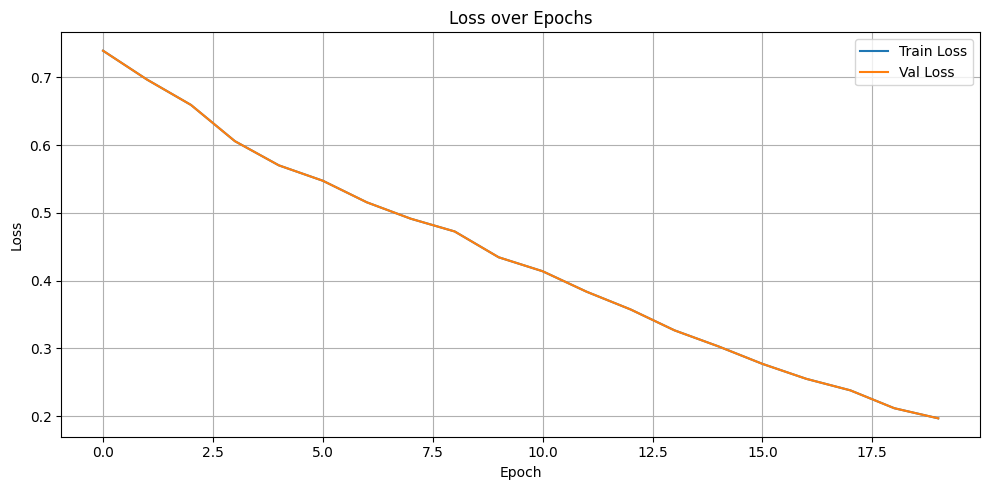

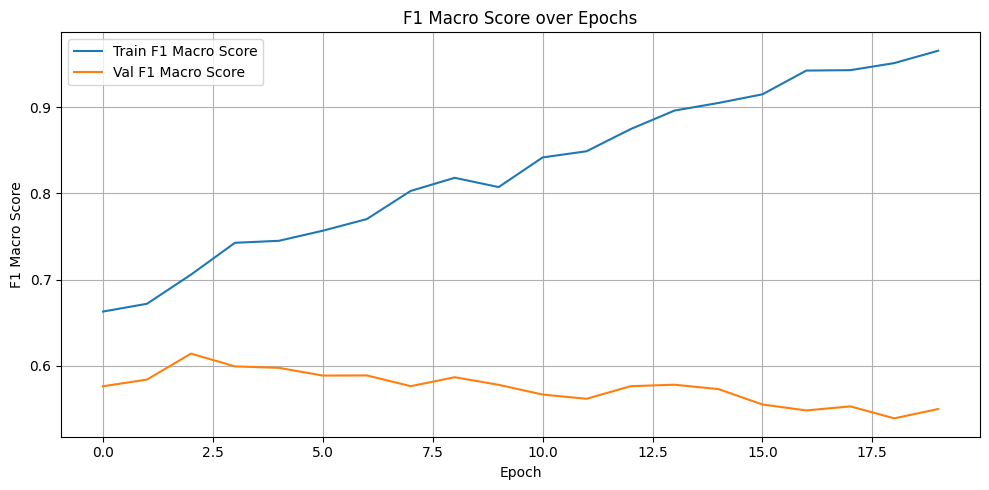

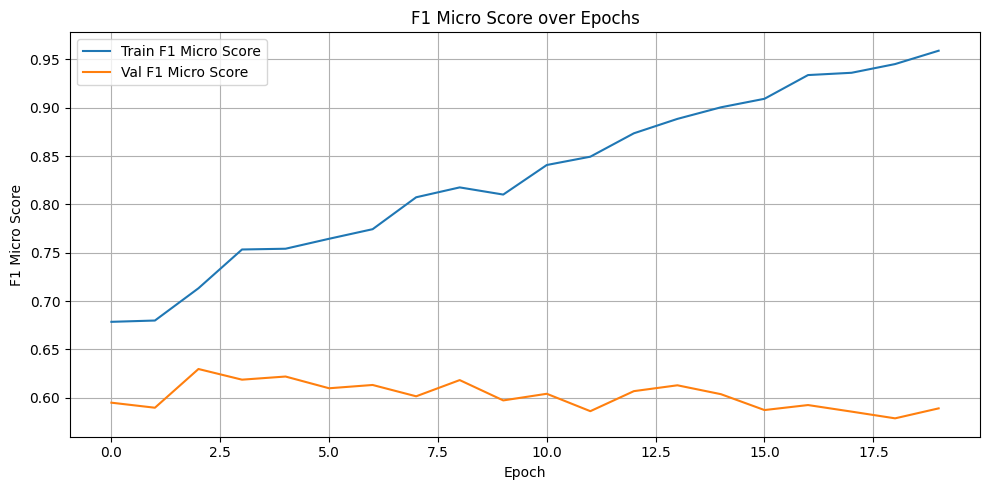

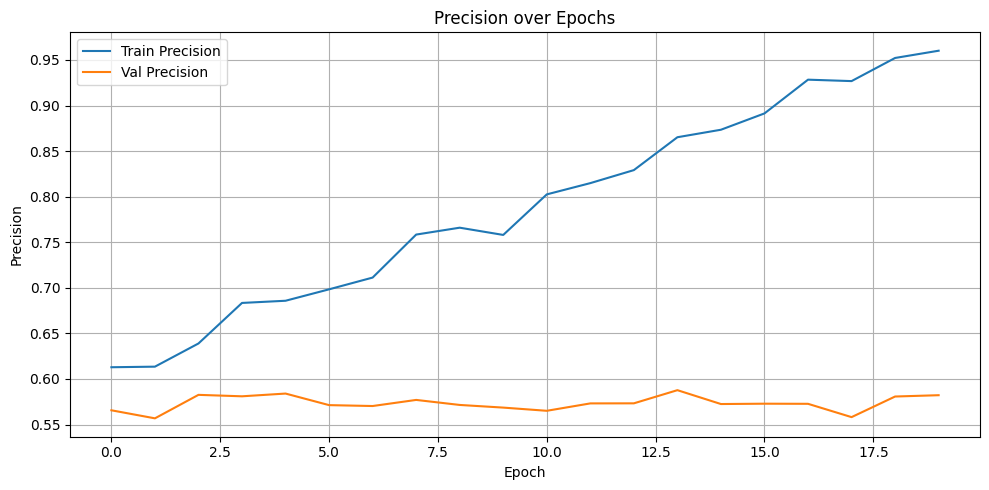

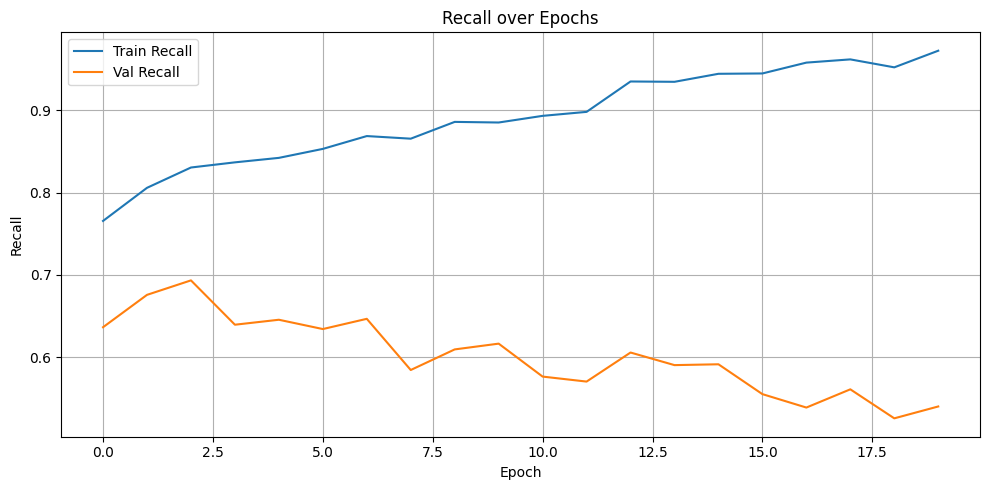

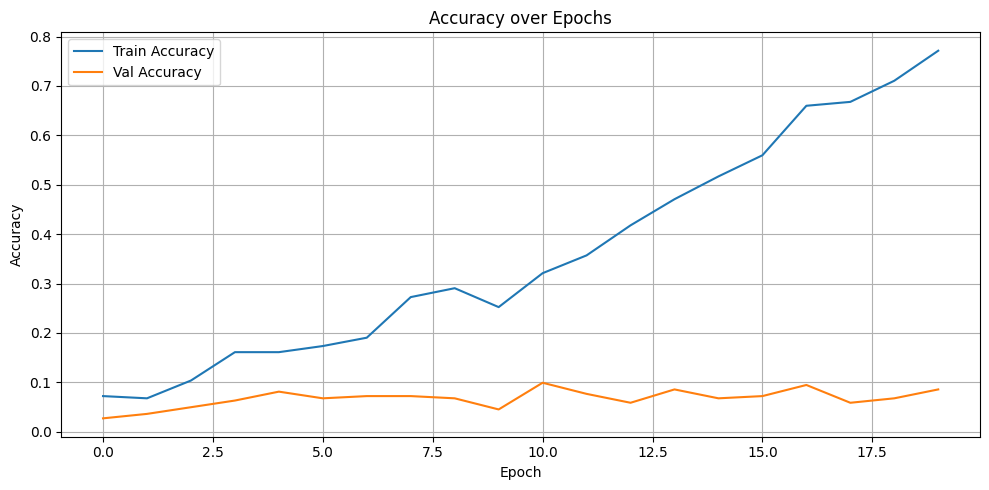

In [115]:
def plot_metrics(train, val, name):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f'Train {name}')
    plt.plot(val, label=f'Val {name}')
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.title(f"{name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_curve.png")
    plt.show()

plot_metrics(train_losses, train_losses, "Loss")
plot_metrics(train_f1macros, val_f1macros, "F1 Macro Score")
plot_metrics(train_f1micros, val_f1micros, "F1 Micro Score")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_accs, val_accs, "Accuracy")

In [116]:
def predict_emotions(text, model, tokenizer, threshold=0.5):
    model.eval()
    encoding = tokenizer(text,
                         max_length=512,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= threshold).astype(int)
    results = {emotion: float(prob) for emotion, prob in zip(all_emotions, probs)}
    predicted_emotions = [emotion for emotion, pred in zip(all_emotions, preds) if pred == 1]
    return predicted_emotions, results

In [117]:
text_ro = "O vreme, a fost greu în ultima vreme, am fost mai bine decât în ultimele patru decembrie reci pe care mi le amintesc. Și îmi văd familia în fiecare lună. Am găsit o fată pe care o iubesc părinții mei. Vine să stea peste noapte și cred că aș putea avea totul. Și îi mulțumesc lui Dumnezeu în fiecare zi pentru fata pe care mi-a trimis-o. Dar știu lucrurile pe care mi le dă, le poate lua. Și te țin în brațe în fiecare noapte. Și acesta e un sentiment cu care vreau să mă obișnuiesc. Dar nu există bărbat mai înspăimântat ca bărbatul care riscă să te piardă."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "For a while, it's been hard lately, I've been better than I've been in the last four cold Decembers that I can remember. And I see my family every month. I found a girl that my parents love. She's coming to stay overnight and I think I could have it all. And I thank God every day for the girl he sent me. But I know the things he gives me, he can take away. And I hold you in my arms every night. And that's a feeling I want to get used to. But there's no man more scared than the man who risks losing you."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.07083829492330551, 'Calmness': 0.7051446437835693, 'Joyful activation': 0.23094365000724792, 'Nostalgia': 0.07712263613939285, 'Power': 0.9150563478469849, 'Sadness': 0.48188313841819763, 'Solemnity': 0.9664605855941772, 'Tenderness': 0.00694513414055109, 'Tension': 0.5813629627227783}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.17878508567810059, 'Calmness': 0.33670350909233093, 'Joyful activation': 0.08086910843849182, 'Nostalgia': 0.8079276084899902, 'Power': 0.11661570519208908, 'Sadness': 0.9275602102279663, 'Solemnity': 0.33750757575035095, 'Tenderness': 0.6666815280914307, 'Tension': 0.4476156234741211}


In [118]:
text_ro = "Simt cum îmi bate inima cu putere, e atât de greu să mă calmez, Sunt prea răbdător? Prea cald, m-a făcut să transpir pe podea (Ooh, transpir pe podea) Pur și simplu nu mai pot suporta (Woah-woah, oh, woah; Ah) Și suntem atât de aproape, văd în ochii tăi Dacă există o șansă o să profit, te implor, te rog dă-mi un semn Aștept de prea mult timp, cred că e timpul, mm-hmm Toată magia asta arde ca un foc înăuntru Și e mult prea cald, fată, ar trebui să ne eliberăm Am așteptat să fiu lângă tine Îmi dau seama cât de mult îți dorești și tu, ooh Toată tensiunea asta, iubito, eliberează-ți corpul (Ha) Suntem doar tu și eu Ne privim in ochi in aceasta cameră aglomerată Felul în care te uiți la mine, nu pot refuza Toată tensiunea asta, iubito, eliberează-ți corpul, da, iubito Coadă de cal așezată exact cum trebuie desfa-o fată, nu Fii timida, mă bucur că am spart gheața. Hai să continuăm să dansăm (Dansăm, dansăm). Iubito, ți-o pot da cum vrei (Cum vrei)."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "I feel my heart pounding, it's so hard to calm down, Am I too patient? Too hot, got me sweating on the floor (Ooh, sweating on the floor) I just can't take it anymore (Woah-woah, oh, woah; Ah) And we're so close, I see it in your eyes If there's a chance I can take it, I'm begging you, please give me a sign I've been waiting too long, I think it's time, mm-hmm All this magic burns like a fire inside And it's way too hot, girl, we should let it loose I've been waiting to be get next to you I realize how much you want it too, ooh All this tension, baby, let your body loose (Ha) It's just you and me Locking eyes inside this crowded room The way you look at me, I can't refuse All this tension, baby, let your body loose, yeah, baby let it loose, ponytail sitting just right, Let it down, girl, don't be shy, I'm just glad we broke the ice. Let's on keep dancing (Dancing, dancing). Baby, I can give it to you any way you want (Any way you want)."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Amazement', 'Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.6655312776565552, 'Calmness': 0.4652685523033142, 'Joyful activation': 0.47801217436790466, 'Nostalgia': 0.5770212411880493, 'Power': 0.16064727306365967, 'Sadness': 0.5227146148681641, 'Solemnity': 0.23594911396503448, 'Tenderness': 0.9132009148597717, 'Tension': 0.1906852126121521}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.1750212162733078, 'Calmness': 0.17301051318645477, 'Joyful activation': 0.16648617386817932, 'Nostalgia': 0.6160711050033569, 'Power': 0.11588877439498901, 'Sadness': 0.8337224125862122, 'Solemnity': 0.20715443789958954, 'Tenderness': 0.8874914050102234, 'Tension': 0.49468278884887695}


In [119]:
text_ro = "Oamenii cred că sunt mare, dar sunt mic. Nu sunt mulțumit de obiective. Mă uit la visele mele, și tot cresc. Îmi dau un nume scării, do-re-mi-fa. Puterea Regelui Uriaș e o armă, urechile mele sunt deschise. O văd în ochii mei, e toxică, capacitatea mea e atât de mare. Sunt ca o furnică lucrătoare. Dar voi depăși durerea și voi deveni un gigant. Ne numesc Dumnezeul Zeilor. Să ne folosim puterile pe care le deținem pentru propriile lor dorințe, să le privim cum explodează. Sunt cunoscut ca un gigant. Nu, nu, nu, sunt, dar neg. Avem locuri de mers, avem locuri în care să curg. Nu sunt mulțumit, îmi doresc mai mult. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, zdrobind lumi sub pământ. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, trecând peste deficiențe. Aleargă, aleargă, aleargă înainte să venim, vino, vino. Ard, arde, arde, pentru că nu am terminat, gata, gata. Aleargă, aleargă, aleargă înainte să venim, vino, vino, sunt un gigant, zdrobind lumile de dedesubt"
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "People think I'm big, but I'm small. I'm not satisfied with goals. I look at my dreams, and I'm still growing. I give my ladder a name, do-re-mi-fa. The power of the Giant King is a weapon, my ears are open. I see it in my eyes, it's toxic, my capacity is so great. I'm like a worker ant. But I will overcome the pain and become a giant. I call ourselves the God of Gods. Let's use the powers we hold for our own desires, let's watch them explode. I'm known as a giant. No, no, no, I am, but I deny it. We have places to walk, we have places to flow. I'm not satisfied, I want more. I'm a giant (Call me, call me, call me, call me, call me). I'm a giant, crushing worlds underground. I'm a giant (Call me, call me, call me, Call me, call me. I'm a giant, overcoming shortcomings. Run, run, run before we come, come, come. Burn, burn, burn, because I'm not done, done, done. Run, run, run before we come, come, come, I'm a giant, crushing the worlds below."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

Predicted emotions: ['Calmness', 'Nostalgia', 'Power', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.252109169960022, 'Calmness': 0.6813281774520874, 'Joyful activation': 0.21082228422164917, 'Nostalgia': 0.5830841660499573, 'Power': 0.5039284229278564, 'Sadness': 0.7456693053245544, 'Solemnity': 0.7808998823165894, 'Tenderness': 0.13111403584480286, 'Tension': 0.57060307264328}
Predicted emotions: ['Calmness', 'Nostalgia', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.3639479875564575, 'Calmness': 0.637726902961731, 'Joyful activation': 0.31854861974716187, 'Nostalgia': 0.6130852699279785, 'Power': 0.4536764323711395, 'Sadness': 0.6753092408180237, 'Solemnity': 0.7362828850746155, 'Tenderness': 0.187067911028862, 'Tension': 0.5126765370368958}
